In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!pip install -q ultralytics==8.3.34 matplotlib scikit-learn torch torchvision

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 887.4/887.4 kB 41.1 MB/s eta 0:00:00


In [ ]:

# =========================================================
# 🚢 NAVAL SHIP DETECTION USING YOLOv8 (Enhanced Bounding Boxes + Clean Annotations)
# =========================================================

# Install dependencies
!pip install -q ultralytics==8.3.34 matplotlib scikit-learn torch torchvision

# Mount Drive
from google.colab import drive
drive.mount('/content/drive')

# Imports
import os, shutil, random, math, glob, torch
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import roc_curve, auc
from ultralytics import YOLO
from urllib.request import urlretrieve

# ---------------------------
# Dataset setup
# ---------------------------
DATASET_PATH = "/content/drive/MyDrive/originaldataset"
MODEL_SAVE_DIR = "/content/drive/MyDrive/YOLOv8_Naval_Training"
os.makedirs(MODEL_SAVE_DIR, exist_ok=True)
yaml_path = "/content/naval_dataset.yaml"

train_images = os.path.join(DATASET_PATH, "train", "images")
train_labels = os.path.join(DATASET_PATH, "train", "labels")
val_images = os.path.join(DATASET_PATH, "val", "images")
val_labels = os.path.join(DATASET_PATH, "val", "labels")

# ---------------------------
# Validation creation (auto split if missing)
# ---------------------------
if not os.path.exists(val_images) or not os.path.exists(val_labels):
    print("⚠️ Validation set missing — creating 10% split from training...")
    os.makedirs(val_images, exist_ok=True)
    os.makedirs(val_labels, exist_ok=True)

    img_patterns = ["*.jpg", "*.jpeg", "*.png"]
    train_img_files = []
    for p in img_patterns:
        train_img_files += glob.glob(os.path.join(train_images, p))
    train_img_files = sorted(train_img_files)

    # 10% split for validation
    k = max(1, math.ceil(0.10 * len(train_img_files)))
    random.seed(42)
    val_files = random.sample(train_img_files, k)

    for img_path in val_files:
        base = os.path.basename(img_path)
        name, _ = os.path.splitext(base)
        shutil.copy2(img_path, os.path.join(val_images, base))
        label_src = os.path.join(train_labels, f"{name}.txt")
        label_dst = os.path.join(val_labels, f"{name}.txt")

        # ✅ Create missing label files correctly
        if os.path.exists(label_src):
            with open(label_src, 'r') as src, open(label_dst, 'w') as dst:
                for line in src:
                    vals = line.strip().split()
                    if len(vals) == 5:
                        dst.write(' '.join(vals) + '\n')
                    else:
                        continue
        else:
            open(label_dst, "w").close()
    print(f"✅ Created validation set with {k} images and aligned labels.")

# ---------------------------
# YAML Configuration
# ---------------------------
yaml_content = f"""
path: {DATASET_PATH}
train: train/images
val: val/images

nc: 5
names:
  0: warship
  1: aircraft_carrier
  2: submarine
  3: oil_carrier
  4: civilian_ship
"""
with open(yaml_path, "w") as f:
    f.write(yaml_content)
print("✅ Dataset YAML created ->", yaml_path)

# ---------------------------
# Download YOLOv8 weights if missing
# ---------------------------
model_path = "/content/yolov8n.pt"
if not os.path.exists(model_path):
    print("⬇️ Downloading yolov8n.pt...")
    urlretrieve("https://github.com/ultralytics/assets/releases/download/v0.0.0/yolov8n.pt", model_path)
    print("✅ Downloaded yolov8n.pt")

# ---------------------------
# Load and Train YOLOv8 model
# ---------------------------
device = 0 if torch.cuda.is_available() else 'cpu'
print("Device selected:", "GPU" if device==0 else "CPU")

model = YOLO(model_path)
print("✅ YOLOv8n model loaded with pretrained weights.")

# 🔥 Training Configuration (Optimized for bounding box accuracy)
print("\n🚀 Starting optimized training for 30 epochs...\n")

results = model.train(
    data=yaml_path,
    epochs=30,
    imgsz=960,
    batch=16,
    optimizer='Adam',
    lr0=0.001,
    weight_decay=0.0005,
    augment=True,
    hsv_h=0.015, hsv_s=0.7, hsv_v=0.4,
    flipud=0.3, fliplr=0.5,
    mosaic=1.0, mixup=0.2,
    translate=0.1,
    scale=0.5,
    degrees=5.0,
    shear=1.0,     # ✅ improved bounding box alignment for tilted ships
    patience=10,
    pretrained=True,
    project="/content/runs/detect",
    name="ship_detection_model_optimized",
    device=device
)

print("\n✅ Training complete!")

# ---------------------------
# Save best weights
# ---------------------------
run_dir = "/content/runs/detect/ship_detection_model_optimized"
best = os.path.join(run_dir, "weights", "best.pt")
if os.path.exists(best):
    cp_path = os.path.join(MODEL_SAVE_DIR, "best_ship_detection_optimized.pt")
    shutil.copy2(best, cp_path)
    print(f"✅ Best model copied to: {cp_path}")
else:
    print("⚠️ best.pt not found.")

# ---------------------------
# Validation
# ---------------------------
print("\n📊 Running validation on optimized model...")
metrics = model.val()
print("✅ Validation complete.")

try:
    print(f"\nmAP50: {metrics.box.map50:.4f}")
    print(f"mAP50-95: {metrics.box.map:.4f}")
    print(f"Precision: {metrics.box.mp:.4f}")
    print(f"Recall: {metrics.box.mr:.4f}")
except Exception:
    pass

# ---------------------------
# Inference
# ---------------------------
from google.colab import files
print("\n📤 Upload one test image for detection...")
uploaded = files.upload()

for fname in uploaded.keys():
    print("Running detection on:", fname)
    model.predict(
        source=fname,
        conf=0.25,
        save=True,
        show_labels=True,    # ✅ show class labels
        show_conf=True,      # ✅ show confidence on bounding boxes
        boxes=True,          # ✅ enable clear bbox rendering
        project="/content/runs/detect",
        name="naval_test_optimized"
    )
    print("✅ Detection complete. Check /content/runs/detect/naval_test_optimized")


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.
✅ Dataset YAML created -> /content/naval_dataset.yaml
⬇️ Downloading yolov8n.pt...
✅ Downloaded yolov8n.pt
Device selected: GPU
✅ YOLOv8n model loaded with pretrained weights.

🚀 Starting optimized training for 30 epochs...

New https://pypi.org/project/ultralytics/8.3.237 available 😃 Update with 'pip install -U ultralytics'
Ultralytics 8.3.34 🚀 Python-3.12.12 torch-2.9.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: task=detect, mode=train, model=/content/yolov8n.pt, data=/content/naval_dataset.yaml, epochs=30, time=None, patience=10, batch=16, imgs

100%|██████████| 755k/755k [00:00<00:00, 23.6MB/s]


Overriding model.yaml nc=80 with nc=5

                   from  n    params  module                                       arguments                     
  0                  -1  1       464  ultralytics.nn.modules.conv.Conv             [3, 16, 3, 2]                 
  1                  -1  1      4672  ultralytics.nn.modules.conv.Conv             [16, 32, 3, 2]                
  2                  -1  1      7360  ultralytics.nn.modules.block.C2f             [32, 32, 1, True]             
  3                  -1  1     18560  ultralytics.nn.modules.conv.Conv             [32, 64, 3, 2]                
  4                  -1  2     49664  ultralytics.nn.modules.block.C2f             [64, 64, 2, True]             
  5                  -1  1     73984  ultralytics.nn.modules.conv.Conv             [64, 128, 3, 2]               
  6                  -1  2    197632  ultralytics.nn.modules.block.C2f             [128, 128, 2, True]           
  7                  -1  1    295424  ultralytics

100%|██████████| 5.35M/5.35M [00:00<00:00, 123MB/s]


AMP: checks passed ✅


train: Scanning /content/drive/MyDrive/originaldataset/train/labels.cache... 1837 images, 0 backgrounds, 0 corrupt: 100%|██████████| 1837/1837 [00:00<?, ?it/s]


albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))


/usr/local/lib/python3.12/dist-packages/ultralytics/data/augment.py:1850: UserWarning: Argument(s) 'quality_lower' are not valid for transform ImageCompression
  A.ImageCompression(quality_lower=75, p=0.0),
val: Scanning /content/drive/MyDrive/originaldataset/val/labels.cache... 184 images, 0 backgrounds, 0 corrupt: 100%|██████████| 184/184 [00:00<?, ?it/s]


Plotting labels to /content/runs/detect/ship_detection_model_optimized/labels.jpg... 
optimizer: Adam(lr=0.001, momentum=0.937) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 960 train, 960 val
Using 2 dataloader workers
Logging results to /content/runs/detect/ship_detection_model_optimized
Starting training for 30 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/30      4.77G      1.656      2.632      2.253         47        960: 100%|██████████| 115/115 [07:11<00:00,  3.75s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:05<00:00,  1.05it/s]

                   all        184        215      0.221      0.437      0.193     0.0491



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/30      4.74G       1.56      2.114      2.148         60        960: 100%|██████████| 115/115 [01:30<00:00,  1.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.22it/s]

                   all        184        215      0.247      0.528      0.292     0.0803



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/30      4.73G      1.567      2.082      2.142         51        960: 100%|██████████| 115/115 [01:31<00:00,  1.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:03<00:00,  1.89it/s]

                   all        184        215      0.534      0.599      0.518      0.153



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/30      4.75G      1.512      1.951      2.066         47        960: 100%|██████████| 115/115 [01:30<00:00,  1.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:04<00:00,  1.36it/s]

                   all        184        215      0.346      0.485      0.329      0.103



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/30      4.73G      1.493      1.898      2.042         45        960: 100%|██████████| 115/115 [01:30<00:00,  1.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.09it/s]

                   all        184        215       0.61      0.619      0.659      0.276



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/30      4.76G      1.481      1.884      2.036         55        960: 100%|██████████| 115/115 [01:34<00:00,  1.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:03<00:00,  1.85it/s]

                   all        184        215      0.468      0.567      0.488      0.177



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/30      4.75G      1.451      1.858      1.996         42        960: 100%|██████████| 115/115 [01:32<00:00,  1.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:03<00:00,  1.50it/s]

                   all        184        215       0.42      0.374       0.33      0.141



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/30      4.73G      1.438      1.833      1.979         48        960: 100%|██████████| 115/115 [01:30<00:00,  1.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:03<00:00,  1.91it/s]

                   all        184        215      0.702      0.565      0.635      0.266



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/30      4.73G      1.393      1.738      1.959         67        960: 100%|██████████| 115/115 [01:30<00:00,  1.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:03<00:00,  1.90it/s]

                   all        184        215      0.556      0.702        0.7       0.34



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/30      4.74G      1.379      1.691       1.93         45        960: 100%|██████████| 115/115 [01:29<00:00,  1.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:04<00:00,  1.41it/s]

                   all        184        215      0.747      0.732      0.783      0.356



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/30      4.75G      1.376      1.657      1.921         48        960: 100%|██████████| 115/115 [01:27<00:00,  1.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:03<00:00,  1.87it/s]

                   all        184        215      0.785      0.647       0.75      0.338



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/30      4.76G      1.383      1.675      1.932         42        960: 100%|██████████| 115/115 [01:28<00:00,  1.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.07it/s]

                   all        184        215      0.683      0.629      0.703      0.314



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/30      4.76G      1.355      1.595      1.901         49        960: 100%|██████████| 115/115 [01:28<00:00,  1.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:03<00:00,  1.81it/s]

                   all        184        215      0.702      0.721      0.747      0.341



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/30      4.72G      1.321      1.586      1.884         49        960: 100%|██████████| 115/115 [01:30<00:00,  1.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:03<00:00,  1.93it/s]

                   all        184        215      0.795       0.74      0.811      0.413



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/30      4.72G      1.318      1.558      1.875         56        960: 100%|██████████| 115/115 [01:28<00:00,  1.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:03<00:00,  1.87it/s]

                   all        184        215      0.794      0.765      0.825      0.439



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/30      4.72G      1.297      1.521      1.849         51        960: 100%|██████████| 115/115 [01:27<00:00,  1.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:03<00:00,  1.79it/s]

                   all        184        215      0.836      0.733      0.828      0.438



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/30      4.72G      1.292      1.514      1.854         36        960: 100%|██████████| 115/115 [01:28<00:00,  1.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.12it/s]

                   all        184        215      0.838      0.802      0.848       0.46



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/30       4.8G      1.293      1.508       1.86         35        960: 100%|██████████| 115/115 [01:29<00:00,  1.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.12it/s]

                   all        184        215      0.825      0.792      0.858      0.452



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/30      4.72G      1.281      1.473      1.824         42        960: 100%|██████████| 115/115 [01:26<00:00,  1.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:03<00:00,  1.66it/s]

                   all        184        215      0.861       0.75      0.842       0.44



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/30      4.75G      1.268      1.455      1.834         50        960: 100%|██████████| 115/115 [01:26<00:00,  1.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:03<00:00,  1.83it/s]

                   all        184        215       0.85      0.816      0.865      0.506


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))


/usr/local/lib/python3.12/dist-packages/ultralytics/data/augment.py:1850: UserWarning: Argument(s) 'quality_lower' are not valid for transform ImageCompression
  A.ImageCompression(quality_lower=75, p=0.0),



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      21/30      4.68G       1.27      1.275      1.947         14        960: 100%|██████████| 115/115 [01:12<00:00,  1.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:03<00:00,  1.97it/s]

                   all        184        215      0.883      0.812      0.885      0.549



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      22/30      4.69G      1.216      1.129      1.883         23        960: 100%|██████████| 115/115 [01:09<00:00,  1.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:03<00:00,  1.58it/s]

                   all        184        215      0.889      0.825      0.886      0.554



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      23/30      4.68G      1.184      1.061      1.857         13        960: 100%|██████████| 115/115 [01:11<00:00,  1.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.14it/s]

                   all        184        215       0.91      0.861      0.897      0.586



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      24/30      4.68G      1.158      1.032      1.824         12        960: 100%|██████████| 115/115 [01:11<00:00,  1.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:03<00:00,  1.60it/s]

                   all        184        215      0.885      0.866      0.901      0.609



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      25/30      4.68G      1.098     0.9635      1.774         18        960: 100%|██████████| 115/115 [01:11<00:00,  1.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.45it/s]

                   all        184        215      0.921      0.835      0.922      0.602



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      26/30      4.69G      1.097     0.9355      1.787         14        960: 100%|██████████| 115/115 [01:11<00:00,  1.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:03<00:00,  1.80it/s]

                   all        184        215       0.91       0.86      0.936      0.649



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      27/30      4.68G      1.049     0.9029      1.718         10        960: 100%|██████████| 115/115 [01:09<00:00,  1.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:03<00:00,  1.92it/s]

                   all        184        215      0.922      0.863      0.929      0.637



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      28/30      4.68G       1.04     0.8818      1.724         11        960: 100%|██████████| 115/115 [01:10<00:00,  1.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.16it/s]

                   all        184        215      0.943      0.865      0.933      0.672



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      29/30      4.68G      1.031     0.8697      1.705         13        960: 100%|██████████| 115/115 [01:10<00:00,  1.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:03<00:00,  1.65it/s]

                   all        184        215       0.91       0.88      0.938      0.675



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      30/30       4.7G       1.01     0.8508      1.687         14        960: 100%|██████████| 115/115 [01:10<00:00,  1.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.14it/s]

                   all        184        215       0.91        0.9      0.943      0.676



30 epochs completed in 0.835 hours.
Optimizer stripped from /content/runs/detect/ship_detection_model_optimized/weights/last.pt, 6.3MB
Optimizer stripped from /content/runs/detect/ship_detection_model_optimized/weights/best.pt, 6.3MB

Validating /content/runs/detect/ship_detection_model_optimized/weights/best.pt...
Ultralytics 8.3.34 🚀 Python-3.12.12 torch-2.9.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
Model summary (fused): 168 layers, 3,006,623 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:07<00:00,  1.28s/it]


                   all        184        215      0.967      0.875      0.944      0.727
               warship         86         89      0.973      0.978       0.99      0.833
      aircraft_carrier         98        126      0.961      0.773      0.899      0.621
Speed: 0.5ms preprocess, 17.4ms inference, 0.0ms loss, 8.7ms postprocess per image
Results saved to /content/runs/detect/ship_detection_model_optimized

✅ Training complete!
✅ Best model copied to: /content/drive/MyDrive/YOLOv8_Naval_Training/best_ship_detection_optimized.pt

📊 Running validation on optimized model...
Ultralytics 8.3.34 🚀 Python-3.12.12 torch-2.9.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
Model summary (fused): 168 layers, 3,006,623 parameters, 0 gradients, 8.1 GFLOPs


val: Scanning /content/drive/MyDrive/originaldataset/val/labels.cache... 184 images, 0 backgrounds, 0 corrupt: 100%|██████████| 184/184 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:08<00:00,  1.34it/s]


                   all        184        215      0.967      0.876      0.944      0.727
               warship         86         89      0.973      0.978       0.99      0.833
      aircraft_carrier         98        126      0.961      0.774      0.899      0.622
Speed: 0.7ms preprocess, 27.2ms inference, 0.0ms loss, 5.5ms postprocess per image
Results saved to /content/runs/detect/ship_detection_model_optimized2
✅ Validation complete.

mAP50: 0.9443
mAP50-95: 0.7274
Precision: 0.9669
Recall: 0.8759

📤 Upload one test image for detection...


KeyboardInterrupt: 

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.
✅ Model loaded for ROC–AUC computation
Running inference on 184 validation images...


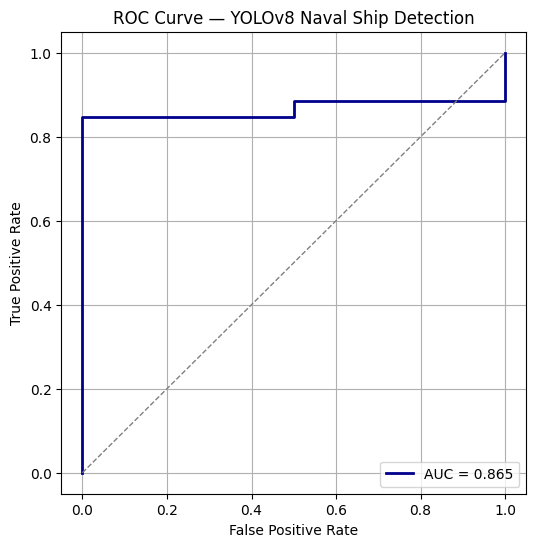

✅ ROC–AUC Computed Successfully — AUC: 0.8654


In [ ]:
# =========================================================
# 📊 ROC–AUC EVALUATION (YOLOv8 Naval Detection)
# =========================================================

import os
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
from ultralytics import YOLO
from glob import glob

# ---------------------------------------------------------
# Load trained YOLOv8 model
# ---------------------------------------------------------
best_model_path = "/content/drive/MyDrive/YOLOv8_Naval_Training/best_ship_detection_optimized.pt"
model = YOLO(best_model_path)
print("✅ Model loaded for ROC–AUC computation")

# ---------------------------------------------------------
# Run inference on validation set
# ---------------------------------------------------------
val_img_dir = "/content/drive/MyDrive/originaldataset/val/images"
image_files = sorted(glob(os.path.join(val_img_dir, "*.jpg")) +
                     glob(os.path.join(val_img_dir, "*.png")) +
                     glob(os.path.join(val_img_dir, "*.jpeg")))

y_true, y_score = [], []

print(f"Running inference on {len(image_files)} validation images...")

for img_path in image_files:
    results = model.predict(source=img_path, conf=0.001, verbose=False)
    pred = results[0]

    # Get predictions
    if pred.boxes is not None and len(pred.boxes) > 0:
        # Highest confidence detection
        confs = pred.boxes.conf.cpu().numpy()
        classes = pred.boxes.cls.cpu().numpy().astype(int)

        # Get predicted class with max confidence
        top_idx = np.argmax(confs)
        y_score.append(confs[top_idx])

        # Read corresponding ground truth label file
        label_path = img_path.replace("/images/", "/labels/").rsplit(".", 1)[0] + ".txt"
        if os.path.exists(label_path):
            with open(label_path, "r") as f:
                gt = f.readline().strip().split()
                true_class = int(gt[0]) if len(gt) > 0 else -1
            y_true.append(1 if classes[top_idx] == true_class else 0)
        else:
            y_true.append(0)
    else:
        y_score.append(0)
        y_true.append(0)

# ---------------------------------------------------------
# Compute ROC and AUC
# ---------------------------------------------------------
y_true = np.array(y_true)
y_score = np.array(y_score)

if len(np.unique(y_true)) > 1:
    fpr, tpr, _ = roc_curve(y_true, y_score)
    roc_auc = auc(fpr, tpr)

    plt.figure(figsize=(6, 6))
    plt.plot(fpr, tpr, color='darkblue', lw=2, label=f"AUC = {roc_auc:.3f}")
    plt.plot([0, 1], [0, 1], color='gray', lw=1, linestyle='--')
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("ROC Curve — YOLOv8 Naval Ship Detection")
    plt.legend(loc="lower right")
    plt.grid(True)
    plt.show()

    print(f"✅ ROC–AUC Computed Successfully — AUC: {roc_auc:.4f}")
else:
    print("⚠️ Only one class detected, ROC–AUC cannot be computed.")


In [ ]:
# =========================================================
# 🚢 CUSTOM BOUNDING BOX INFERENCE FOR NAVAL SHIP DETECTION
# =========================================================

import cv2
import numpy as np
from ultralytics import YOLO
from google.colab import files

# Load your trained model
model = YOLO("/content/drive/MyDrive/YOLOv8_Naval_Training/best_ship_detection_optimized.pt")
print("✅ Model Loaded!")

# Class names from your YAML configuration
class_names = ["warship", "aircraft_carrier", "submarine", "oil_carrier", "civilian_ship"]

# Upload an image
print("📤 Upload any naval image for testing...")
uploaded = files.upload()

for filename in uploaded.keys():
    print(f"🔍 Detecting on: {filename}")

    # Run the model on the image
    results = model.predict(source=filename, conf=0.25, verbose=False)
    result = results[0]  # Get the first (and only) result

    # Read the image using OpenCV
    image = cv2.imread(filename)
    h, w = image.shape[:2]

    # If there are detections
    if result.boxes is not None and len(result.boxes) > 0:
        for box in result.boxes:
            # Extract box coordinates and confidence
            x1, y1, x2, y2 = map(int, box.xyxy[0].cpu().numpy())
            conf = box.conf[0].cpu().numpy()
            cls = int(box.cls[0].cpu().numpy())

            # Draw the bounding box
            cv2.rectangle(image, (x1, y1), (x2, y2), (0, 255, 0), 2)  # Green box

            # Prepare the label with class name and confidence
            label = f"{class_names[cls]}: {conf:.2f}"

            # Calculate text size
            font = cv2.FONT_HERSHEY_SIMPLEX
            font_scale = 0.5
            thickness = 1
            text_size, _ = cv2.getTextSize(label, font, font_scale, thickness)

            # Draw a filled rectangle behind the text for readability
            cv2.rectangle(image, (x1, y1 - text_size[1] - 10), (x1 + text_size[0], y1), (0, 255, 0), -1)

            # Put the label text above the bounding box
            cv2.putText(image, label, (x1, y1 - 5), font, font_scale, (0, 0, 0), thickness, lineType=cv2.LINE_AA)

    # Save the annotated image
    output_path = f"/content/runs/detect/{filename}_annotated.jpg"
    cv2.imwrite(output_path, image)
    print(f"✅ Detection complete. Check the output image at: {output_path}")

# Note: You can also display the image in Colab using cv2_imshow if needed.


✅ Model Loaded!
📤 Upload any naval image for testing...


Saving Arleigh-Burke-Modern-Weapons_png_jpg.rf.73ffe27595344ff41f867888dccca392.jpg to Arleigh-Burke-Modern-Weapons_png_jpg.rf.73ffe27595344ff41f867888dccca392.jpg
🔍 Detecting on: Arleigh-Burke-Modern-Weapons_png_jpg.rf.73ffe27595344ff41f867888dccca392.jpg
✅ Detection complete. Check the output image at: /content/runs/detect/Arleigh-Burke-Modern-Weapons_png_jpg.rf.73ffe27595344ff41f867888dccca392.jpg_annotated.jpg


In [ ]:
# =========================================================
# 🔀 STEP 1: CREATE FEDERATED CLIENT DATA FROM SINGLE DATASET
# =========================================================

import os, shutil, random, glob

BASE_DATASET = "/content/drive/MyDrive/originaldataset"
FED_DATASET = "/content/drive/MyDrive/federated_data"
NUM_CLIENTS = 3
random.seed(42)

train_imgs = os.path.join(BASE_DATASET, "train/images")
train_lbls = os.path.join(BASE_DATASET, "train/labels")
val_imgs = os.path.join(BASE_DATASET, "val/images")
val_lbls = os.path.join(BASE_DATASET, "val/labels")

# Create folders
for i in range(1, NUM_CLIENTS + 1):
    os.makedirs(f"{FED_DATASET}/client{i}/train/images", exist_ok=True)
    os.makedirs(f"{FED_DATASET}/client{i}/train/labels", exist_ok=True)
    os.makedirs(f"{FED_DATASET}/client{i}/val/images", exist_ok=True)
    os.makedirs(f"{FED_DATASET}/client{i}/val/labels", exist_ok=True)

images = sorted(glob.glob(train_imgs + "/*.jpg") +
                glob.glob(train_imgs + "/*.png") +
                glob.glob(train_imgs + "/*.jpeg"))

random.shuffle(images)
splits = [images[i::NUM_CLIENTS] for i in range(NUM_CLIENTS)]

# Distribute images
for idx, client_imgs in enumerate(splits):
    cid = idx + 1
    for img_path in client_imgs:
        name = os.path.basename(img_path)
        label = name.rsplit(".", 1)[0] + ".txt"

        shutil.copy2(img_path, f"{FED_DATASET}/client{cid}/train/images/{name}")

        lbl_src = os.path.join(train_lbls, label)
        lbl_dst = f"{FED_DATASET}/client{cid}/train/labels/{label}"

        if os.path.exists(lbl_src):
            shutil.copy2(lbl_src, lbl_dst)
        else:
            open(lbl_dst, "w").close()

# Copy SAME validation data to all clients
for i in range(1, NUM_CLIENTS + 1):
    shutil.copytree(val_imgs, f"{FED_DATASET}/client{i}/val/images", dirs_exist_ok=True)
    shutil.copytree(val_lbls, f"{FED_DATASET}/client{i}/val/labels", dirs_exist_ok=True)

print("✅ STEP 1 COMPLETE: Federated datasets created")


✅ STEP 1 COMPLETE: Federated datasets created


In [ ]:
# =========================================================
# 🌍 FEDERATED LEARNING (FedAvg) FOR YOLOv8 — GOOGLE COLAB
# =========================================================

!pip install -q ultralytics torch numpy

from ultralytics import YOLO
import torch
import os
import copy
import yaml
import numpy as np

# ---------------------------------------------------------
# MOUNT DRIVE
# ---------------------------------------------------------
from google.colab import drive
drive.mount('/content/drive')

# ---------------------------------------------------------
# CONFIGURATION
# ---------------------------------------------------------
NUM_CLIENTS = 3
NUM_ROUNDS = 3          # Communication rounds
LOCAL_EPOCHS = 5        # Each client trains locally

BASE_MODEL = "/content/drive/MyDrive/YOLOv8_Naval_Training/best_ship_detection_optimized.pt"
FED_DATA = "/content/drive/MyDrive/federated_data"
GLOBAL_DIR = "/content/drive/MyDrive/federated_global"
os.makedirs(GLOBAL_DIR, exist_ok=True)

DEVICE = 0 if torch.cuda.is_available() else "cpu"
print("🖥 Device:", "GPU" if DEVICE == 0 else "CPU")

# ---------------------------------------------------------
# CLASS CONFIG (SAME AS YOUR YAML)
# ---------------------------------------------------------
CLASS_NAMES = [
    "warship",
    "aircraft_carrier",
    "submarine",
    "oil_carrier",
    "civilian_ship"
]

# ---------------------------------------------------------
# CREATE CLIENT YAMLs
# ---------------------------------------------------------
def create_client_yaml(client_id):
    yaml_path = f"/content/client_{client_id}.yaml"
    data = {
        "path": f"{FED_DATA}/client{client_id}",
        "train": "train/images",
        "val": "val/images",
        "nc": len(CLASS_NAMES),
        "names": CLASS_NAMES
    }
    with open(yaml_path, "w") as f:
        yaml.dump(data, f)
    return yaml_path

# ---------------------------------------------------------
# FEDERATED AVERAGING FUNCTION
# ---------------------------------------------------------
def fedavg(state_dicts):
    avg_dict = {}

    for key in state_dicts[0].keys():
        if state_dicts[0][key].dtype in [torch.float32, torch.float16]:
            avg_dict[key] = torch.zeros_like(state_dicts[0][key])
            for sd in state_dicts:
                avg_dict[key] += sd[key]
            avg_dict[key] /= len(state_dicts)
        else:
            avg_dict[key] = state_dicts[0][key]

    return avg_dict


# ---------------------------------------------------------
# INITIAL GLOBAL MODEL
# ---------------------------------------------------------
global_model = YOLO(BASE_MODEL)
global_weights = global_model.model.state_dict()

# ---------------------------------------------------------
# FEDERATED TRAINING
# ---------------------------------------------------------
for rnd in range(1, NUM_ROUNDS + 1):
    print(f"\n🌍 FEDERATED ROUND {rnd}/{NUM_ROUNDS}")
    client_weights = []

    for client_id in range(1, NUM_CLIENTS + 1):
        print(f"\n🔹 Training Client {client_id}")

        client_yaml = create_client_yaml(client_id)

        # Load global model into client
        client_model = YOLO(BASE_MODEL)
        client_model.model.load_state_dict(global_weights)

        # Local training
        client_model.train(
            data=client_yaml,
            epochs=LOCAL_EPOCHS,
            imgsz=960,
            batch=8,
            device=DEVICE,
            optimizer="Adam",
            lr0=0.0005,
            project="/content/runs/federated",
            name=f"client_{client_id}_round_{rnd}",
            verbose=False
        )

        # Collect client weights
        client_weights.append(
            copy.deepcopy(client_model.model.state_dict())
        )

        print(f"✅ Client {client_id} training complete")

    # Aggregate weights (FedAvg)
    global_weights = fedavg(client_weights)
    global_model.model.load_state_dict(global_weights)

    # Save global model after each round
    round_path = f"{GLOBAL_DIR}/global_round_{rnd}.pt"
    torch.save(global_model.model.state_dict(), round_path)
    print(f"\n🌐 Global model saved → {round_path}")

# ---------------------------------------------------------
# SAVE FINAL FEDERATED MODEL
# ---------------------------------------------------------
FINAL_MODEL_PATH = f"{GLOBAL_DIR}/federated_global_best.pt"
torch.save(global_model.model.state_dict(), FINAL_MODEL_PATH)

print("\n✅ FEDERATED LEARNING COMPLETE")
print("🏁 Final FL Model Saved at:")
print(FINAL_MODEL_PATH)


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
🖥 Device: GPU

🌍 FEDERATED ROUND 1/3

🔹 Training Client 1
New https://pypi.org/project/ultralytics/8.3.237 available 😃 Update with 'pip install -U ultralytics'
Ultralytics 8.3.34 🚀 Python-3.12.12 torch-2.9.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: task=detect, mode=train, model=/content/drive/MyDrive/YOLOv8_Naval_Training/best_ship_detection_optimized.pt, data=/content/client_1.yaml, epochs=5, time=None, patience=100, batch=8, imgsz=960, save=True, save_period=-1, cache=False, device=0, workers=8, project=/content/runs/federated, name=client_1_round_12, exist_ok=False, pretrained=True, optimizer=Adam, verbose=False, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=v

train: Scanning /content/drive/MyDrive/federated_data/client1/train/labels.cache... 613 images, 0 backgrounds, 0 corrupt: 100%|██████████| 613/613 [00:00<?, ?it/s]

albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))



/usr/local/lib/python3.12/dist-packages/ultralytics/data/augment.py:1850: UserWarning: Argument(s) 'quality_lower' are not valid for transform ImageCompression
  A.ImageCompression(quality_lower=75, p=0.0),
val: Scanning /content/drive/MyDrive/federated_data/client1/val/labels.cache... 184 images, 0 backgrounds, 0 corrupt: 100%|██████████| 184/184 [00:00<?, ?it/s]


Plotting labels to /content/runs/federated/client_1_round_12/labels.jpg... 
optimizer: Adam(lr=0.0005, momentum=0.937) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 960 train, 960 val
Using 2 dataloader workers
Logging results to /content/runs/federated/client_1_round_12
Starting training for 5 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        1/5      2.52G      1.188      1.263      1.734         12        960: 100%|██████████| 77/77 [00:28<00:00,  2.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:03<00:00,  3.16it/s]


                   all        184        215       0.55       0.57      0.449       0.25

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        2/5      2.47G      1.122      1.204      1.688         15        960: 100%|██████████| 77/77 [00:26<00:00,  2.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:03<00:00,  3.68it/s]

                   all        184        215      0.731      0.822      0.871      0.558



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        3/5      2.47G      1.045      1.137      1.628         18        960: 100%|██████████| 77/77 [00:26<00:00,  2.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:04<00:00,  2.88it/s]


                   all        184        215       0.86      0.853      0.903      0.593

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        4/5      2.46G      1.052      1.141      1.622         15        960: 100%|██████████| 77/77 [00:25<00:00,  3.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:04<00:00,  2.96it/s]

                   all        184        215      0.901      0.816      0.911       0.62



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        5/5      2.46G      1.028      1.077      1.614         16        960: 100%|██████████| 77/77 [00:25<00:00,  3.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:03<00:00,  3.32it/s]


                   all        184        215      0.883      0.876      0.922      0.638

5 epochs completed in 0.050 hours.
Optimizer stripped from /content/runs/federated/client_1_round_12/weights/last.pt, 6.3MB
Optimizer stripped from /content/runs/federated/client_1_round_12/weights/best.pt, 6.3MB

Validating /content/runs/federated/client_1_round_12/weights/best.pt...
Ultralytics 8.3.34 🚀 Python-3.12.12 torch-2.9.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
Model summary (fused): 168 layers, 3,006,623 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:04<00:00,  2.52it/s]


                   all        184        215      0.883      0.878      0.922      0.639
Speed: 0.5ms preprocess, 5.7ms inference, 0.0ms loss, 4.1ms postprocess per image
Results saved to /content/runs/federated/client_1_round_12
✅ Client 1 training complete

🔹 Training Client 2
New https://pypi.org/project/ultralytics/8.3.237 available 😃 Update with 'pip install -U ultralytics'
Ultralytics 8.3.34 🚀 Python-3.12.12 torch-2.9.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: task=detect, mode=train, model=/content/drive/MyDrive/YOLOv8_Naval_Training/best_ship_detection_optimized.pt, data=/content/client_2.yaml, epochs=5, time=None, patience=100, batch=8, imgsz=960, save=True, save_period=-1, cache=False, device=0, workers=8, project=/content/runs/federated, name=client_2_round_12, exist_ok=False, pretrained=True, optimizer=Adam, verbose=False, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, fr

train: Scanning /content/drive/MyDrive/federated_data/client2/train/labels.cache... 612 images, 0 backgrounds, 0 corrupt: 100%|██████████| 612/612 [00:00<?, ?it/s]

albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))



/usr/local/lib/python3.12/dist-packages/ultralytics/data/augment.py:1850: UserWarning: Argument(s) 'quality_lower' are not valid for transform ImageCompression
  A.ImageCompression(quality_lower=75, p=0.0),
val: Scanning /content/drive/MyDrive/federated_data/client2/val/labels.cache... 184 images, 0 backgrounds, 0 corrupt: 100%|██████████| 184/184 [00:00<?, ?it/s]


Plotting labels to /content/runs/federated/client_2_round_12/labels.jpg... 
optimizer: Adam(lr=0.0005, momentum=0.937) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 960 train, 960 val
Using 2 dataloader workers
Logging results to /content/runs/federated/client_2_round_12
Starting training for 5 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        1/5      2.53G      1.199       1.31      1.769         10        960: 100%|██████████| 77/77 [00:27<00:00,  2.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:04<00:00,  2.56it/s]

                   all        184        215      0.733      0.635      0.717      0.357



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        2/5       2.5G      1.125       1.18      1.712         12        960: 100%|██████████| 77/77 [00:25<00:00,  2.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:03<00:00,  3.82it/s]

                   all        184        215      0.823      0.802      0.867      0.524



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        3/5      2.49G       1.12      1.177      1.685         16        960: 100%|██████████| 77/77 [00:25<00:00,  2.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:04<00:00,  2.81it/s]

                   all        184        215      0.846      0.873      0.911        0.6



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        4/5      2.49G      1.083      1.133       1.64         12        960: 100%|██████████| 77/77 [00:24<00:00,  3.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:04<00:00,  2.59it/s]

                   all        184        215      0.907      0.851      0.911      0.631



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        5/5      2.48G      1.066      1.105      1.622         12        960: 100%|██████████| 77/77 [00:25<00:00,  3.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:03<00:00,  3.18it/s]

                   all        184        215      0.949      0.855      0.923      0.643



5 epochs completed in 0.050 hours.
Optimizer stripped from /content/runs/federated/client_2_round_12/weights/last.pt, 6.3MB
Optimizer stripped from /content/runs/federated/client_2_round_12/weights/best.pt, 6.3MB

Validating /content/runs/federated/client_2_round_12/weights/best.pt...
Ultralytics 8.3.34 🚀 Python-3.12.12 torch-2.9.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
Model summary (fused): 168 layers, 3,006,623 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:05<00:00,  2.15it/s]


                   all        184        215      0.947      0.855      0.922      0.643
Speed: 0.6ms preprocess, 6.5ms inference, 0.0ms loss, 5.9ms postprocess per image
Results saved to /content/runs/federated/client_2_round_12
✅ Client 2 training complete

🔹 Training Client 3
New https://pypi.org/project/ultralytics/8.3.237 available 😃 Update with 'pip install -U ultralytics'
Ultralytics 8.3.34 🚀 Python-3.12.12 torch-2.9.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: task=detect, mode=train, model=/content/drive/MyDrive/YOLOv8_Naval_Training/best_ship_detection_optimized.pt, data=/content/client_3.yaml, epochs=5, time=None, patience=100, batch=8, imgsz=960, save=True, save_period=-1, cache=False, device=0, workers=8, project=/content/runs/federated, name=client_3_round_12, exist_ok=False, pretrained=True, optimizer=Adam, verbose=False, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, fr

train: Scanning /content/drive/MyDrive/federated_data/client3/train/labels.cache... 612 images, 0 backgrounds, 0 corrupt: 100%|██████████| 612/612 [00:00<?, ?it/s]

albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))



/usr/local/lib/python3.12/dist-packages/ultralytics/data/augment.py:1850: UserWarning: Argument(s) 'quality_lower' are not valid for transform ImageCompression
  A.ImageCompression(quality_lower=75, p=0.0),
val: Scanning /content/drive/MyDrive/federated_data/client3/val/labels.cache... 184 images, 0 backgrounds, 0 corrupt: 100%|██████████| 184/184 [00:00<?, ?it/s]


Plotting labels to /content/runs/federated/client_3_round_12/labels.jpg... 
optimizer: Adam(lr=0.0005, momentum=0.937) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 960 train, 960 val
Using 2 dataloader workers
Logging results to /content/runs/federated/client_3_round_12
Starting training for 5 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        1/5      2.55G      1.169      1.267      1.727         12        960: 100%|██████████| 77/77 [00:27<00:00,  2.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:04<00:00,  2.51it/s]

                   all        184        215      0.579      0.548       0.45      0.242



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        2/5       2.5G      1.143      1.204      1.698         14        960: 100%|██████████| 77/77 [00:26<00:00,  2.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:04<00:00,  2.95it/s]

                   all        184        215       0.82      0.744      0.839      0.514



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        3/5      2.49G      1.121      1.197      1.679         17        960: 100%|██████████| 77/77 [00:25<00:00,  3.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:04<00:00,  2.79it/s]

                   all        184        215      0.903      0.854      0.901      0.618



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        4/5      2.49G      1.087      1.135      1.656          8        960: 100%|██████████| 77/77 [00:26<00:00,  2.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:03<00:00,  3.86it/s]

                   all        184        215      0.913      0.843      0.913      0.619



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        5/5      2.49G      1.061      1.111      1.626         10        960: 100%|██████████| 77/77 [00:26<00:00,  2.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:03<00:00,  3.85it/s]

                   all        184        215      0.917      0.846      0.909      0.629



5 epochs completed in 0.050 hours.
Optimizer stripped from /content/runs/federated/client_3_round_12/weights/last.pt, 6.3MB
Optimizer stripped from /content/runs/federated/client_3_round_12/weights/best.pt, 6.3MB

Validating /content/runs/federated/client_3_round_12/weights/best.pt...
Ultralytics 8.3.34 🚀 Python-3.12.12 torch-2.9.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
Model summary (fused): 168 layers, 3,006,623 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:05<00:00,  2.35it/s]


                   all        184        215      0.918      0.846      0.909      0.629
Speed: 0.7ms preprocess, 5.8ms inference, 0.0ms loss, 5.8ms postprocess per image
Results saved to /content/runs/federated/client_3_round_12
✅ Client 3 training complete

🌐 Global model saved → /content/drive/MyDrive/federated_global/global_round_1.pt

🌍 FEDERATED ROUND 2/3

🔹 Training Client 1
New https://pypi.org/project/ultralytics/8.3.237 available 😃 Update with 'pip install -U ultralytics'
Ultralytics 8.3.34 🚀 Python-3.12.12 torch-2.9.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: task=detect, mode=train, model=/content/drive/MyDrive/YOLOv8_Naval_Training/best_ship_detection_optimized.pt, data=/content/client_1.yaml, epochs=5, time=None, patience=100, batch=8, imgsz=960, save=True, save_period=-1, cache=False, device=0, workers=8, project=/content/runs/federated, name=client_1_round_2, exist_ok=False, pretrained=True, optimizer=Adam, verbose=False, seed=0, deterministic=True, single_cls=F

train: Scanning /content/drive/MyDrive/federated_data/client1/train/labels.cache... 613 images, 0 backgrounds, 0 corrupt: 100%|██████████| 613/613 [00:00<?, ?it/s]

albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))



/usr/local/lib/python3.12/dist-packages/ultralytics/data/augment.py:1850: UserWarning: Argument(s) 'quality_lower' are not valid for transform ImageCompression
  A.ImageCompression(quality_lower=75, p=0.0),
val: Scanning /content/drive/MyDrive/federated_data/client1/val/labels.cache... 184 images, 0 backgrounds, 0 corrupt: 100%|██████████| 184/184 [00:00<?, ?it/s]


Plotting labels to /content/runs/federated/client_1_round_2/labels.jpg... 
optimizer: Adam(lr=0.0005, momentum=0.937) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 960 train, 960 val
Using 2 dataloader workers
Logging results to /content/runs/federated/client_1_round_2
Starting training for 5 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        1/5      2.52G      1.072      1.126      1.626         12        960: 100%|██████████| 77/77 [00:26<00:00,  2.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:04<00:00,  2.94it/s]

                   all        184        215      0.849      0.832      0.878      0.545



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        2/5      2.47G      1.059      1.129      1.632         15        960: 100%|██████████| 77/77 [00:25<00:00,  3.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:04<00:00,  2.91it/s]

                   all        184        215      0.857      0.733      0.874      0.571



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        3/5      2.47G      1.017      1.083      1.585         18        960: 100%|██████████| 77/77 [00:25<00:00,  3.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:04<00:00,  2.92it/s]

                   all        184        215      0.811      0.819      0.865      0.594



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        4/5      2.47G      1.037      1.107       1.61         15        960: 100%|██████████| 77/77 [00:26<00:00,  2.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:03<00:00,  3.52it/s]

                   all        184        215      0.863      0.832      0.896      0.612



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        5/5      2.47G      1.007      1.052       1.59         16        960: 100%|██████████| 77/77 [00:26<00:00,  2.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:03<00:00,  3.76it/s]

                   all        184        215      0.843      0.875      0.917      0.644



5 epochs completed in 0.050 hours.
Optimizer stripped from /content/runs/federated/client_1_round_2/weights/last.pt, 6.3MB
Optimizer stripped from /content/runs/federated/client_1_round_2/weights/best.pt, 6.3MB

Validating /content/runs/federated/client_1_round_2/weights/best.pt...
Ultralytics 8.3.34 🚀 Python-3.12.12 torch-2.9.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
Model summary (fused): 168 layers, 3,006,623 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:04<00:00,  2.46it/s]


                   all        184        215      0.842      0.881      0.917      0.643
Speed: 0.6ms preprocess, 5.3ms inference, 0.0ms loss, 4.5ms postprocess per image
Results saved to /content/runs/federated/client_1_round_2
✅ Client 1 training complete

🔹 Training Client 2
New https://pypi.org/project/ultralytics/8.3.237 available 😃 Update with 'pip install -U ultralytics'
Ultralytics 8.3.34 🚀 Python-3.12.12 torch-2.9.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: task=detect, mode=train, model=/content/drive/MyDrive/YOLOv8_Naval_Training/best_ship_detection_optimized.pt, data=/content/client_2.yaml, epochs=5, time=None, patience=100, batch=8, imgsz=960, save=True, save_period=-1, cache=False, device=0, workers=8, project=/content/runs/federated, name=client_2_round_2, exist_ok=False, pretrained=True, optimizer=Adam, verbose=False, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, free

train: Scanning /content/drive/MyDrive/federated_data/client2/train/labels.cache... 612 images, 0 backgrounds, 0 corrupt: 100%|██████████| 612/612 [00:00<?, ?it/s]

albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))



/usr/local/lib/python3.12/dist-packages/ultralytics/data/augment.py:1850: UserWarning: Argument(s) 'quality_lower' are not valid for transform ImageCompression
  A.ImageCompression(quality_lower=75, p=0.0),
val: Scanning /content/drive/MyDrive/federated_data/client2/val/labels.cache... 184 images, 0 backgrounds, 0 corrupt: 100%|██████████| 184/184 [00:00<?, ?it/s]


Plotting labels to /content/runs/federated/client_2_round_2/labels.jpg... 
optimizer: Adam(lr=0.0005, momentum=0.937) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 960 train, 960 val
Using 2 dataloader workers
Logging results to /content/runs/federated/client_2_round_2
Starting training for 5 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        1/5      2.52G      1.088      1.174      1.654         10        960: 100%|██████████| 77/77 [00:27<00:00,  2.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:04<00:00,  2.59it/s]

                   all        184        215      0.867      0.758      0.823      0.437



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        2/5      2.49G       1.06      1.095      1.641         12        960: 100%|██████████| 77/77 [00:26<00:00,  2.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:03<00:00,  3.18it/s]

                   all        184        215      0.848      0.813      0.863      0.559



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        3/5      2.48G      1.054       1.13      1.635         16        960: 100%|██████████| 77/77 [00:24<00:00,  3.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:04<00:00,  2.57it/s]

                   all        184        215      0.893      0.863      0.908      0.609



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        4/5      2.48G      1.051      1.096      1.611         12        960: 100%|██████████| 77/77 [00:25<00:00,  3.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:03<00:00,  3.08it/s]

                   all        184        215      0.901      0.848      0.912      0.634



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        5/5      2.48G      1.038      1.072      1.596         12        960: 100%|██████████| 77/77 [00:26<00:00,  2.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:03<00:00,  3.71it/s]

                   all        184        215      0.936      0.834      0.918      0.646



5 epochs completed in 0.050 hours.
Optimizer stripped from /content/runs/federated/client_2_round_2/weights/last.pt, 6.3MB
Optimizer stripped from /content/runs/federated/client_2_round_2/weights/best.pt, 6.3MB

Validating /content/runs/federated/client_2_round_2/weights/best.pt...
Ultralytics 8.3.34 🚀 Python-3.12.12 torch-2.9.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
Model summary (fused): 168 layers, 3,006,623 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:04<00:00,  2.49it/s]


                   all        184        215      0.936      0.833      0.918      0.646
Speed: 0.6ms preprocess, 5.6ms inference, 0.0ms loss, 5.6ms postprocess per image
Results saved to /content/runs/federated/client_2_round_2
✅ Client 2 training complete

🔹 Training Client 3
New https://pypi.org/project/ultralytics/8.3.237 available 😃 Update with 'pip install -U ultralytics'
Ultralytics 8.3.34 🚀 Python-3.12.12 torch-2.9.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: task=detect, mode=train, model=/content/drive/MyDrive/YOLOv8_Naval_Training/best_ship_detection_optimized.pt, data=/content/client_3.yaml, epochs=5, time=None, patience=100, batch=8, imgsz=960, save=True, save_period=-1, cache=False, device=0, workers=8, project=/content/runs/federated, name=client_3_round_2, exist_ok=False, pretrained=True, optimizer=Adam, verbose=False, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, free

train: Scanning /content/drive/MyDrive/federated_data/client3/train/labels.cache... 612 images, 0 backgrounds, 0 corrupt: 100%|██████████| 612/612 [00:00<?, ?it/s]

albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))



/usr/local/lib/python3.12/dist-packages/ultralytics/data/augment.py:1850: UserWarning: Argument(s) 'quality_lower' are not valid for transform ImageCompression
  A.ImageCompression(quality_lower=75, p=0.0),
val: Scanning /content/drive/MyDrive/federated_data/client3/val/labels.cache... 184 images, 0 backgrounds, 0 corrupt: 100%|██████████| 184/184 [00:00<?, ?it/s]


Plotting labels to /content/runs/federated/client_3_round_2/labels.jpg... 
optimizer: Adam(lr=0.0005, momentum=0.937) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 960 train, 960 val
Using 2 dataloader workers
Logging results to /content/runs/federated/client_3_round_2
Starting training for 5 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        1/5      2.56G      1.075      1.153      1.641         12        960: 100%|██████████| 77/77 [00:28<00:00,  2.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:04<00:00,  2.87it/s]

                   all        184        215      0.786      0.808      0.833       0.51



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        2/5       2.5G      1.078      1.114      1.635         14        960: 100%|██████████| 77/77 [00:25<00:00,  3.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:04<00:00,  2.79it/s]

                   all        184        215      0.778       0.83      0.856      0.524



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        3/5      2.49G      1.098      1.107      1.654         17        960: 100%|██████████| 77/77 [00:25<00:00,  3.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:04<00:00,  2.87it/s]

                   all        184        215      0.893        0.9      0.907       0.62



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        4/5      2.48G      1.074      1.089      1.643          8        960: 100%|██████████| 77/77 [00:26<00:00,  2.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:03<00:00,  3.83it/s]

                   all        184        215      0.906      0.885      0.916      0.641



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        5/5      2.48G      1.038       1.07      1.609         10        960: 100%|██████████| 77/77 [00:26<00:00,  2.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:03<00:00,  3.83it/s]

                   all        184        215      0.889      0.882      0.916      0.642



5 epochs completed in 0.050 hours.
Optimizer stripped from /content/runs/federated/client_3_round_2/weights/last.pt, 6.3MB
Optimizer stripped from /content/runs/federated/client_3_round_2/weights/best.pt, 6.3MB

Validating /content/runs/federated/client_3_round_2/weights/best.pt...
Ultralytics 8.3.34 🚀 Python-3.12.12 torch-2.9.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
Model summary (fused): 168 layers, 3,006,623 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:05<00:00,  2.10it/s]


                   all        184        215      0.891      0.882      0.916      0.642
Speed: 0.6ms preprocess, 6.3ms inference, 0.0ms loss, 5.9ms postprocess per image
Results saved to /content/runs/federated/client_3_round_2
✅ Client 3 training complete

🌐 Global model saved → /content/drive/MyDrive/federated_global/global_round_2.pt

🌍 FEDERATED ROUND 3/3

🔹 Training Client 1
New https://pypi.org/project/ultralytics/8.3.237 available 😃 Update with 'pip install -U ultralytics'
Ultralytics 8.3.34 🚀 Python-3.12.12 torch-2.9.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: task=detect, mode=train, model=/content/drive/MyDrive/YOLOv8_Naval_Training/best_ship_detection_optimized.pt, data=/content/client_1.yaml, epochs=5, time=None, patience=100, batch=8, imgsz=960, save=True, save_period=-1, cache=False, device=0, workers=8, project=/content/runs/federated, name=client_1_round_3, exist_ok=False, pretrained=True, optimizer=Adam, verbose=False, seed=0, deterministic=True, single_cls=Fa

train: Scanning /content/drive/MyDrive/federated_data/client1/train/labels.cache... 613 images, 0 backgrounds, 0 corrupt: 100%|██████████| 613/613 [00:00<?, ?it/s]

albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))



/usr/local/lib/python3.12/dist-packages/ultralytics/data/augment.py:1850: UserWarning: Argument(s) 'quality_lower' are not valid for transform ImageCompression
  A.ImageCompression(quality_lower=75, p=0.0),
val: Scanning /content/drive/MyDrive/federated_data/client1/val/labels.cache... 184 images, 0 backgrounds, 0 corrupt: 100%|██████████| 184/184 [00:00<?, ?it/s]


Plotting labels to /content/runs/federated/client_1_round_3/labels.jpg... 
optimizer: Adam(lr=0.0005, momentum=0.937) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 960 train, 960 val
Using 2 dataloader workers
Logging results to /content/runs/federated/client_1_round_3
Starting training for 5 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        1/5      2.53G      1.033      1.098      1.594         12        960: 100%|██████████| 77/77 [00:27<00:00,  2.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:03<00:00,  3.35it/s]

                   all        184        215      0.851       0.78      0.836      0.509



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        2/5       2.5G      1.024      1.115      1.594         15        960: 100%|██████████| 77/77 [00:24<00:00,  3.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:04<00:00,  2.69it/s]

                   all        184        215      0.919      0.761        0.9      0.574



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        3/5      2.49G     0.9899      1.075      1.571         18        960: 100%|██████████| 77/77 [00:26<00:00,  2.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:02<00:00,  4.05it/s]

                   all        184        215      0.904      0.862      0.895        0.6



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        4/5      2.49G      1.019      1.095      1.593         15        960: 100%|██████████| 77/77 [00:26<00:00,  2.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:03<00:00,  3.73it/s]

                   all        184        215      0.892      0.829      0.902      0.617



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        5/5      2.49G     0.9945      1.043      1.582         16        960: 100%|██████████| 77/77 [00:26<00:00,  2.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:03<00:00,  3.82it/s]

                   all        184        215      0.919       0.84      0.924      0.646



5 epochs completed in 0.050 hours.
Optimizer stripped from /content/runs/federated/client_1_round_3/weights/last.pt, 6.3MB
Optimizer stripped from /content/runs/federated/client_1_round_3/weights/best.pt, 6.3MB

Validating /content/runs/federated/client_1_round_3/weights/best.pt...
Ultralytics 8.3.34 🚀 Python-3.12.12 torch-2.9.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
Model summary (fused): 168 layers, 3,006,623 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:06<00:00,  1.79it/s]


                   all        184        215      0.915       0.84      0.924      0.648
Speed: 0.7ms preprocess, 6.9ms inference, 0.0ms loss, 6.9ms postprocess per image
Results saved to /content/runs/federated/client_1_round_3
✅ Client 1 training complete

🔹 Training Client 2
New https://pypi.org/project/ultralytics/8.3.237 available 😃 Update with 'pip install -U ultralytics'
Ultralytics 8.3.34 🚀 Python-3.12.12 torch-2.9.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: task=detect, mode=train, model=/content/drive/MyDrive/YOLOv8_Naval_Training/best_ship_detection_optimized.pt, data=/content/client_2.yaml, epochs=5, time=None, patience=100, batch=8, imgsz=960, save=True, save_period=-1, cache=False, device=0, workers=8, project=/content/runs/federated, name=client_2_round_3, exist_ok=False, pretrained=True, optimizer=Adam, verbose=False, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, free

train: Scanning /content/drive/MyDrive/federated_data/client2/train/labels.cache... 612 images, 0 backgrounds, 0 corrupt: 100%|██████████| 612/612 [00:00<?, ?it/s]

albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))



/usr/local/lib/python3.12/dist-packages/ultralytics/data/augment.py:1850: UserWarning: Argument(s) 'quality_lower' are not valid for transform ImageCompression
  A.ImageCompression(quality_lower=75, p=0.0),
val: Scanning /content/drive/MyDrive/federated_data/client2/val/labels.cache... 184 images, 0 backgrounds, 0 corrupt: 100%|██████████| 184/184 [00:00<?, ?it/s]


Plotting labels to /content/runs/federated/client_2_round_3/labels.jpg... 
optimizer: Adam(lr=0.0005, momentum=0.937) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 960 train, 960 val
Using 2 dataloader workers
Logging results to /content/runs/federated/client_2_round_3
Starting training for 5 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        1/5      2.53G      1.041      1.131      1.611         10        960: 100%|██████████| 77/77 [00:27<00:00,  2.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:03<00:00,  3.65it/s]

                   all        184        215       0.86      0.725      0.807      0.451



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        2/5       2.5G      1.012       1.06      1.602         12        960: 100%|██████████| 77/77 [00:26<00:00,  2.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:03<00:00,  3.52it/s]

                   all        184        215      0.842      0.868       0.88       0.57



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        3/5      2.49G      1.029      1.105      1.608         16        960: 100%|██████████| 77/77 [00:26<00:00,  2.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:03<00:00,  3.73it/s]

                   all        184        215      0.872       0.87      0.904      0.611



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        4/5      2.49G      1.035      1.072      1.589         12        960: 100%|██████████| 77/77 [00:26<00:00,  2.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:03<00:00,  3.78it/s]

                   all        184        215      0.902      0.853      0.914      0.619



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        5/5      2.48G      1.029      1.056      1.591         12        960: 100%|██████████| 77/77 [00:26<00:00,  2.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:03<00:00,  3.64it/s]


                   all        184        215      0.878       0.86      0.917      0.632

5 epochs completed in 0.050 hours.
Optimizer stripped from /content/runs/federated/client_2_round_3/weights/last.pt, 6.3MB
Optimizer stripped from /content/runs/federated/client_2_round_3/weights/best.pt, 6.3MB

Validating /content/runs/federated/client_2_round_3/weights/best.pt...
Ultralytics 8.3.34 🚀 Python-3.12.12 torch-2.9.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
Model summary (fused): 168 layers, 3,006,623 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:05<00:00,  2.36it/s]


                   all        184        215      0.879      0.862      0.917      0.632
Speed: 0.6ms preprocess, 5.3ms inference, 0.0ms loss, 6.0ms postprocess per image
Results saved to /content/runs/federated/client_2_round_3
✅ Client 2 training complete

🔹 Training Client 3
New https://pypi.org/project/ultralytics/8.3.237 available 😃 Update with 'pip install -U ultralytics'
Ultralytics 8.3.34 🚀 Python-3.12.12 torch-2.9.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: task=detect, mode=train, model=/content/drive/MyDrive/YOLOv8_Naval_Training/best_ship_detection_optimized.pt, data=/content/client_3.yaml, epochs=5, time=None, patience=100, batch=8, imgsz=960, save=True, save_period=-1, cache=False, device=0, workers=8, project=/content/runs/federated, name=client_3_round_3, exist_ok=False, pretrained=True, optimizer=Adam, verbose=False, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, free

train: Scanning /content/drive/MyDrive/federated_data/client3/train/labels.cache... 612 images, 0 backgrounds, 0 corrupt: 100%|██████████| 612/612 [00:00<?, ?it/s]

albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))



/usr/local/lib/python3.12/dist-packages/ultralytics/data/augment.py:1850: UserWarning: Argument(s) 'quality_lower' are not valid for transform ImageCompression
  A.ImageCompression(quality_lower=75, p=0.0),
val: Scanning /content/drive/MyDrive/federated_data/client3/val/labels.cache... 184 images, 0 backgrounds, 0 corrupt: 100%|██████████| 184/184 [00:00<?, ?it/s]


Plotting labels to /content/runs/federated/client_3_round_3/labels.jpg... 
optimizer: Adam(lr=0.0005, momentum=0.937) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 960 train, 960 val
Using 2 dataloader workers
Logging results to /content/runs/federated/client_3_round_3
Starting training for 5 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        1/5      2.55G      1.026      1.083      1.588         12        960: 100%|██████████| 77/77 [00:27<00:00,  2.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:03<00:00,  3.46it/s]

                   all        184        215      0.738      0.715      0.758      0.392



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        2/5       2.5G      1.039      1.049      1.593         14        960: 100%|██████████| 77/77 [00:26<00:00,  2.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:03<00:00,  3.85it/s]

                   all        184        215      0.858       0.87        0.9      0.586



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        3/5      2.48G      1.068      1.077      1.623         17        960: 100%|██████████| 77/77 [00:25<00:00,  2.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:03<00:00,  3.91it/s]

                   all        184        215      0.905      0.905      0.917      0.627



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        4/5      2.48G      1.059      1.062      1.626          8        960: 100%|██████████| 77/77 [00:26<00:00,  2.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:03<00:00,  3.90it/s]

                   all        184        215      0.925      0.874      0.922      0.654



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        5/5      2.48G       1.03      1.037      1.603         10        960: 100%|██████████| 77/77 [00:25<00:00,  3.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:03<00:00,  3.03it/s]

                   all        184        215      0.894      0.859      0.914      0.642



5 epochs completed in 0.050 hours.
Optimizer stripped from /content/runs/federated/client_3_round_3/weights/last.pt, 6.3MB
Optimizer stripped from /content/runs/federated/client_3_round_3/weights/best.pt, 6.3MB

Validating /content/runs/federated/client_3_round_3/weights/best.pt...
Ultralytics 8.3.34 🚀 Python-3.12.12 torch-2.9.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
Model summary (fused): 168 layers, 3,006,623 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:04<00:00,  2.45it/s]


                   all        184        215      0.923      0.874      0.922      0.653
Speed: 0.6ms preprocess, 6.2ms inference, 0.0ms loss, 4.8ms postprocess per image
Results saved to /content/runs/federated/client_3_round_3
✅ Client 3 training complete

🌐 Global model saved → /content/drive/MyDrive/federated_global/global_round_3.pt

✅ FEDERATED LEARNING COMPLETE
🏁 Final FL Model Saved at:
/content/drive/MyDrive/federated_global/federated_global_best.pt


In [ ]:
from ultralytics import YOLO
import torch

# 1️⃣ Load base architecture
model = YOLO("/content/drive/MyDrive/YOLOv8_Naval_Training/best_ship_detection_optimized.pt")

# 2️⃣ Load federated weights
state_dict = torch.load(
    "/content/drive/MyDrive/federated_global/federated_global_best.pt",
    map_location="cuda"
)

model.model.load_state_dict(state_dict)

# 3️⃣ Run inference
model.predict(
    source="/content/drive/MyDrive/originaldataset/test/images",
    imgsz=960,
    conf=0.4,
    save=True
)



image 1/329 /content/drive/MyDrive/originaldataset/test/images/AUSS-Ronald-Reagan-Amazon_png_jpg.rf.e7e1324af39c6874428993900ec3641b.jpg: 960x960 1 warship, 12.2ms
image 2/329 /content/drive/MyDrive/originaldataset/test/images/Aircraft-Carrier_2-3-_png_jpg.rf.34ef0c12252dd5516c70251b29ea12f4.jpg: 960x960 (no detections), 12.2ms
image 3/329 /content/drive/MyDrive/originaldataset/test/images/Aircraft-Carrier_2-4-_png_jpg.rf.4ded92491586585c14a874d4ad256e47.jpg: 960x960 (no detections), 12.2ms
image 4/329 /content/drive/MyDrive/originaldataset/test/images/Aircraft-Carrier_2-8-_png_jpg.rf.194829abeb91956851bc99fe28879b18.jpg: 960x960 1 warship, 12.3ms
image 5/329 /content/drive/MyDrive/originaldataset/test/images/Aircraft-Carrier_21_png_jpg.rf.175a6782571b6b68fefef22fb141bf4d.jpg: 960x960 (no detections), 12.3ms
image 6/329 /content/drive/MyDrive/originaldataset/test/images/Arleigh-Burke-DIMDEX_png_jpg.rf.c3c1f852b2606eb3696f27b3adc3ef68.jpg: 960x960 1 warship, 12.6ms
image 7/329 /content

[ultralytics.engine.results.Results object with attributes:
 
 boxes: ultralytics.engine.results.Boxes object
 keypoints: None
 masks: None
 names: {0: 'warship', 1: 'aircraft_carrier', 2: 'submarine', 3: 'oil_carrier', 4: 'civilian_ship'}
 obb: None
 orig_img: array([[[201, 171, 136],
         [203, 173, 138],
         [204, 176, 142],
         ...,
         [195, 131,   0],
         [195, 131,   0],
         [195, 131,   0]],
 
        [[199, 169, 134],
         [200, 170, 135],
         [202, 174, 140],
         ...,
         [195, 131,   0],
         [195, 131,   0],
         [195, 131,   0]],
 
        [[198, 170, 135],
         [199, 171, 136],
         [203, 175, 141],
         ...,
         [195, 131,   0],
         [195, 131,   0],
         [195, 131,   0]],
 
        ...,
 
        [[ 82,  34,   6],
         [ 82,  34,   6],
         [ 80,  32,   4],
         ...,
         [ 87,  44,   1],
         [ 87,  45,   0],
         [ 88,  46,   1]],
 
        [[ 84,  36,   8],
      

In [ ]:
!pip install -U ultralytics


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 18.5 MB/s eta 0:00:00


In [ ]:
!pip install -U ultralytics torch torchvision torchaudio


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 899.7/899.7 MB 742.5 kB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 594.3/594.3 MB 1.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.2/10.2 MB 129.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 88.0/88.0 MB 9.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 954.8/954.8 kB 59.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 706.8/706.8 MB 1.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 193.1/193.1 MB 6.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 70.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.6/63.6 MB 14.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 267.5/267.5 MB 4.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 288.2/288.2 MB 5.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 287.2/287.2 MB 5.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 

In [ ]:
from ultralytics import YOLO
import torch

model = YOLO("/content/drive/MyDrive/YOLOv8_Naval_Training/best_ship_detection_optimized.pt")

state_dict = torch.load(
    "/content/drive/MyDrive/federated_global/federated_global_best.pt",
    map_location="cpu"
)

model.model.load_state_dict(state_dict)

print("✅ Federated YOLO model loaded successfully")


Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.
✅ Federated YOLO model loaded successfully


In [ ]:
%%writefile /content/drive/MyDrive/originaldataset/data.yaml
path: /content/drive/MyDrive/originaldataset
train: train/images
val: val/images
test: test/images

nc: 5
names:
  - warship
  - aircraft_carrier
  - submarine
  - oil_carrier
  - civilian_ship



Overwriting /content/drive/MyDrive/originaldataset/data.yaml


In [ ]:
!cat /content/drive/MyDrive/originaldataset/data.yaml



path: /content/drive/MyDrive/originaldataset
train: train/images
val: val/images
test: test/images

nc: 5
names:
  - warship
  - aircraft_carrier
  - submarine
  - oil_carrier
  - civilian_ship



In [ ]:
metrics = model.val(
    data="/content/drive/MyDrive/originaldataset/data.yaml",
    imgsz=960,
    conf=0.25,
    device="cpu",
    plots=True
)


Ultralytics 8.3.237 🚀 Python-3.12.12 torch-2.9.1+cu128 CPU (AMD EPYC 7B12)
val: Fast image access ✅ (ping: 1.3±1.5 ms, read: 0.4±0.5 MB/s, size: 44.9 KB)
val: Scanning /content/drive/MyDrive/originaldataset/val/labels.cache... 184 images, 0 backgrounds, 0 corrupt: 100% ━━━━━━━━━━━━ 184/184 228.7Kit/s 0.0s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 12/12 7.7s/it 1:33
                   all        184        215      0.909      0.896      0.933      0.706
               warship         86         89      0.915      0.966      0.974      0.768
      aircraft_carrier         98        126      0.904      0.825      0.892      0.644
Speed: 15.2ms preprocess, 471.5ms inference, 0.0ms loss, 0.9ms postprocess per image
Results saved to /content/runs/detect/val3


In [ ]:
print("\n📊 FEDERATED YOLOv8 PERFORMANCE")
print(f"Precision (P)  : {metrics.box.mp:.4f}")
print(f"Recall (R)     : {metrics.box.mr:.4f}")
print(f"mAP@0.50       : {metrics.box.map50:.4f}")
print(f"mAP@0.50–0.95  : {metrics.box.map:.4f}")



📊 FEDERATED YOLOv8 PERFORMANCE
Precision (P)  : 0.9094
Recall (R)     : 0.8958
mAP@0.50       : 0.9331
mAP@0.50–0.95  : 0.7060


In [ ]:
!pip install scikit-learn matplotlib


In [ ]:
!pip install -U ultralytics scikit-learn matplotlib



     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.8/52.8 kB 4.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 22.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.9/8.9 MB 105.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.7/8.7 MB 107.2 MB/s eta 0:00:00
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 1.6.1
    Uninstalling scikit-learn-1.6.1:
      Successfully uninstalled scikit-learn-1.6.1
  Attempting uninstall: matplotlib
    Found existing installation: matplotlib 3.10.0
    Uninstalling matplotlib-3.10.0:
      Successfully uninstalled matplotlib-3.10.0


In [ ]:
from ultralytics import YOLO
print("Ultralytics imported successfully ✅")


Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.
Ultralytics imported successfully ✅


✅ Federated YOLOv8 model loaded for ROC–AUC computation
🔍 Running inference on 184 validation images...


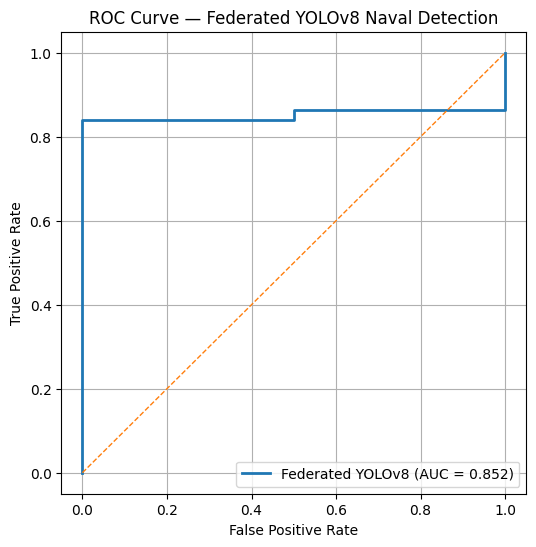

✅ Federated ROC–AUC Score: 0.8516


In [ ]:
# =========================================================
# 📊 ROC–AUC EVALUATION — FEDERATED YOLOv8 (Naval Detection)
# =========================================================

import os
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
from ultralytics import YOLO
from glob import glob
import torch

# ---------------------------------------------------------
# Load YOLOv8 base architecture
# ---------------------------------------------------------
BASE_MODEL = "/content/drive/MyDrive/YOLOv8_Naval_Training/best_ship_detection_optimized.pt"
FED_WEIGHTS = "/content/drive/MyDrive/federated_global/federated_global_best.pt"

model = YOLO(BASE_MODEL)

# Load federated weights
state_dict = torch.load(FED_WEIGHTS, map_location="cpu")
model.model.load_state_dict(state_dict)

print("✅ Federated YOLOv8 model loaded for ROC–AUC computation")

# ---------------------------------------------------------
# Validation images
# ---------------------------------------------------------
val_img_dir = "/content/drive/MyDrive/originaldataset/val/images"
image_files = sorted(
    glob(os.path.join(val_img_dir, "*.jpg")) +
    glob(os.path.join(val_img_dir, "*.png")) +
    glob(os.path.join(val_img_dir, "*.jpeg"))
)

y_true, y_score = [], []

print(f"🔍 Running inference on {len(image_files)} validation images...")

# ---------------------------------------------------------
# Inference loop
# ---------------------------------------------------------
for img_path in image_files:
    results = model.predict(
        source=img_path,
        conf=0.001,
        device="cpu",
        verbose=False
    )

    pred = results[0]

    if pred.boxes is not None and len(pred.boxes) > 0:
        confs = pred.boxes.conf.cpu().numpy()
        classes = pred.boxes.cls.cpu().numpy().astype(int)

        top_idx = np.argmax(confs)
        y_score.append(confs[top_idx])

        label_path = img_path.replace("/images/", "/labels/").rsplit(".", 1)[0] + ".txt"

        if os.path.exists(label_path):
            with open(label_path, "r") as f:
                gt = f.readline().strip().split()
                true_class = int(gt[0]) if len(gt) > 0 else -1

            y_true.append(1 if classes[top_idx] == true_class else 0)
        else:
            y_true.append(0)
    else:
        y_score.append(0.0)
        y_true.append(0)

# ---------------------------------------------------------
# ROC–AUC Computation
# ---------------------------------------------------------
y_true = np.array(y_true)
y_score = np.array(y_score)

if len(np.unique(y_true)) > 1:
    fpr, tpr, _ = roc_curve(y_true, y_score)
    roc_auc = auc(fpr, tpr)

    plt.figure(figsize=(6, 6))
    plt.plot(fpr, tpr, lw=2, label=f"Federated YOLOv8 (AUC = {roc_auc:.3f})")
    plt.plot([0, 1], [0, 1], linestyle="--", lw=1)
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("ROC Curve — Federated YOLOv8 Naval Detection")
    plt.legend(loc="lower right")
    plt.grid(True)
    plt.show()

    print(f"✅ Federated ROC–AUC Score: {roc_auc:.4f}")
else:
    print("⚠️ ROC–AUC cannot be computed (single class detected)")


In [ ]:
from ultralytics import YOLO
import torch

# Load base YOLO architecture
model = YOLO("/content/drive/MyDrive/YOLOv8_Naval_Training/best_ship_detection_optimized.pt")

# Load federated weights
fed_weights = torch.load(
    "/content/drive/MyDrive/federated_global/federated_global_best.pt",
    map_location="cpu"
)

model.model.load_state_dict(fed_weights)

# Save COMPLETE YOLO model (architecture + weights)
FINAL_MODEL = "/content/drive/MyDrive/federated_yolov8_naval.pt"
model.save(FINAL_MODEL)

print("✅ Final Federated YOLO Model Saved:", FINAL_MODEL)


✅ Final Federated YOLO Model Saved: /content/drive/MyDrive/federated_yolov8_naval.pt


✅ Model loaded


Saving MiConv-com__USS-Eisenhower-Reddit_png_jpg.rf.49ee94baabb50df92e4e1239fef125a0.jpg to MiConv-com__USS-Eisenhower-Reddit_png_jpg.rf.49ee94baabb50df92e4e1239fef125a0.jpg

image 1/1 /content/MiConv-com__USS-Eisenhower-Reddit_png_jpg.rf.49ee94baabb50df92e4e1239fef125a0.jpg: 960x960 1 warship, 362.9ms
Speed: 13.5ms preprocess, 362.9ms inference, 0.9ms postprocess per image at shape (1, 3, 960, 960)


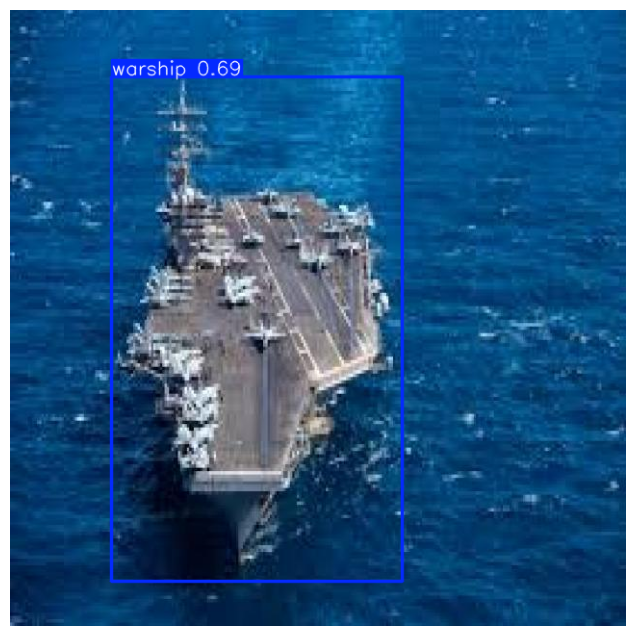

📌 Detection Results:
Class: warship | Confidence: 0.692


In [ ]:
from google.colab import files
from ultralytics import YOLO
import cv2
import matplotlib.pyplot as plt

# Load saved federated model
MODEL_PATH = "/content/drive/MyDrive/federated_yolov8_naval.pt"
model = YOLO(MODEL_PATH)
print("✅ Model loaded")

# Upload image manually
uploaded = files.upload()
image_path = list(uploaded.keys())[0]

# Run detection
results = model.predict(
    source=image_path,
    imgsz=960,
    conf=0.4
)

# Show output image
img = results[0].plot()
plt.figure(figsize=(8,8))
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.axis("off")
plt.show()

# Print detection details
print("📌 Detection Results:")
for box in results[0].boxes:
    cls = int(box.cls)
    conf = float(box.conf)
    print(f"Class: {results[0].names[cls]} | Confidence: {conf:.3f}")
